# Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

# Открываем и кратко описываем данные, ищем связи

In [2]:
dir = 'D:\\Книги\\Программирование\\ML_contests_хакатоны\\Всероссийский_хакатон_2024\\train_dataset_soc_dem_train\\'

In [3]:
ae = pd.read_csv(dir + 'all_events.csv')

In [4]:
te = pd.read_csv(dir + 'train_events.csv')
vi = pd.read_csv(dir + 'video_info_v2.csv')
tt = pd.read_csv(dir + 'train_targets.csv')

In [5]:
# Оценка количества пропусков
ae.isnull().sum(), te.isnull().sum(), vi.isnull().sum(), tt.isnull().sum()

(event_timestamp         0
 region                  0
 ua_device_type          0
 ua_client_type         13
 ua_os              519630
 ua_client_name         13
 total_watchtime         0
 rutube_video_id         0
 viewer_uid              0
 dtype: int64,
 event_timestamp         0
 region                  0
 ua_device_type          0
 ua_client_type          0
 ua_os              117671
 ua_client_name          0
 total_watchtime         0
 rutube_video_id         0
 viewer_uid              0
 dtype: int64,
 rutube_video_id    0
 title              0
 category           0
 duration           0
 author_id          0
 dtype: int64,
 viewer_uid    0
 age           0
 sex           0
 age_class     0
 dtype: int64)

In [6]:
ae.ua_os.value_counts()

ua_os
Android                 5846495
Windows                 1492259
iOS                      429418
Mac                      121609
GNU/Linux                 22654
iPadOS                     4418
Ubuntu                     1535
android tv                  758
Windows Phone               162
Fire OS                     121
HarmonyOS                   118
MeeGo                        84
BlackBerry OS                81
BlackBerry Tablet OS         80
Symbian                      53
Windows CE                   49
KaiOS                        34
Fedora                       24
CyanogenMod                  23
MocorDroid                    7
Windows RT                    4
SUSE                          3
Solaris                       2
Symbian OS Series 60          1
Kubuntu                       1
Chrome OS                     1
Name: count, dtype: int64

Большинство платформ ('ua_os') - Android, что свидетельствует о предпочтительном просмотре с мобильного устройства.
Для поиска возможности заполнить этот пропуски нужно исследовать другие данные, и связи 'ua_os' с остальными фичами.
Возможно, придётся пропустить признак 'ua_os' для экономии времени, а также с учётом собственного опыта решения задачи по использованию промо-кодов, где данный признак не сыграл роли https://github.com/VsevolodMisyurin/dodohack

In [7]:
ae.ua_client_type.value_counts()  

ua_client_type
mobile app    5422565
browser       3016838
av                208
Name: count, dtype: int64

In [8]:
ae.ua_client_name.value_counts()

ua_client_name
Rutube              5415545
Chrome               822447
Yandex Browser       701136
Chrome Mobile        674439
Mobile Safari        226530
                     ...   
Stargon                   1
Petal Search App          1
Phoenix Browser           1
Puffin                    1
Facebook                  1
Name: count, Length: 106, dtype: int64

Предполагаем заполнить пропуски в признаках 'ua_client_type' и 'ua_client_name' модальным значением этих признаков.
Но только в случае, если они понадобятся для формирования модели. 

In [9]:
ae.shape, te.shape, vi.shape, tt.shape

((8439624, 9), (1759616, 9), (481480, 5), (180012, 4))

In [10]:
print(ae.columns, '\n', te.columns, '\n', vi.columns, '\n', tt.columns)

Index(['event_timestamp', 'region', 'ua_device_type', 'ua_client_type',
       'ua_os', 'ua_client_name', 'total_watchtime', 'rutube_video_id',
       'viewer_uid'],
      dtype='object') 
 Index(['event_timestamp', 'region', 'ua_device_type', 'ua_client_type',
       'ua_os', 'ua_client_name', 'total_watchtime', 'rutube_video_id',
       'viewer_uid'],
      dtype='object') 
 Index(['rutube_video_id', 'title', 'category', 'duration', 'author_id'], dtype='object') 
 Index(['viewer_uid', 'age', 'sex', 'age_class'], dtype='object')


In [11]:
ae.head(2)

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid
0,2024-06-01 13:08:30+03:00,Tatarstan Republic,smartphone,browser,Android,Chrome Mobile,60,video_395879,10813370
1,2024-06-01 14:30:00+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,60,video_216518,10512324


In [12]:
te.head(2)

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341


In [13]:
vi.head(2)

,rutube_video_id,title,category,duration,author_id
0,video_185549,Как собрать букет из мыльных тюльпанов - Силик...,Хобби,1559160,1015054
1,video_111035,"Осторожно, Киберземляне!, 1 сезон, 12 серия",Сериалы,1320007,1002180


In [14]:
tt.head(2)

,viewer_uid,age,sex,age_class
0,10087154,30,male,1
1,10908708,25,female,1


In [15]:
tt.age_class.value_counts()

age_class
2    65600
1    63131
3    43690
0     7591
Name: count, dtype: int64

In [16]:
tt.groupby(['age_class']).mean(numeric_only=True)

,viewer_uid,age
age_class,,
0,1.045421e+07,18.557107
1,1.030511e+07,25.640620
2,1.029194e+07,35.379070
3,1.027697e+07,46.309224


In [17]:
tt.groupby(['age_class']).min(numeric_only=True)

,viewer_uid,age
age_class,,
0,10001203,11
1,10000009,21
2,10000001,31
3,10000002,41


In [18]:
tt.groupby(['age_class']).max(numeric_only=True)

,viewer_uid,age
age_class,,
0,11140818,20
1,11140875,30
2,11140888,40
3,11140872,54


Странно, что только от 11 до 54, но ладно.

In [19]:
# Посмотрим на id пользователей, сравним датасеты ae и te
ae.viewer_uid.nunique(), te.viewer_uid.nunique(), tt.viewer_uid.nunique()

(960885, 180012, 180012)

In [20]:
te_uid = te.viewer_uid.unique()
sum(ae['viewer_uid'].isin(te_uid))  # Не совпало, пользователей с одинаковым viewer_uid в датасетах ae и te нет, как и обсуждалось

0

In [21]:
sum(tt['viewer_uid'].isin(te_uid))
# Совпало, значит, характеристики пользователей из train_targets можно пристегнуть к train_events через viewer_uid

180012

In [22]:
# Посмотрим на id видео
ae.rutube_video_id.nunique(), te.rutube_video_id.nunique()

(324450, 126248)

In [23]:
te_rid = te.rutube_video_id.unique()
sum(ae['rutube_video_id'].isin(te_rid))  # Совпало. Число не обозначает, что , так как совпадения могли быть более одного раза

7827012

In [24]:
vi_vi_id = vi.rutube_video_id.unique()
sum(te['rutube_video_id'].isin(vi_vi_id))  # Вот и ладушки, можно связать датасеты train_events и video_info_v2 через признак rutube_video_id

1759616

In [25]:
sum(ae['rutube_video_id'].isin(vi_vi_id))

8439624

Итак, мы можем связать train_targets с train_events через viewer_uid, и train_targets с video_info_v2 через rutube_video_id.
Можно также связать all_events с video_info_v2 через rutube_video_id. Однако стоит продолжить анализ, и только после сформировать новые признаки.

# EDA

Цель - установить, какие особенности видео предпочтительны для мужчин и женщин, а также как возраст отражается на предпочтениях. Необходимо также наметить признаки, которые будут использованы для формирования модели.

In [26]:
# Исследование зависимости возраста от различных признаков

In [27]:
# Начнём с te (train_events)
te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759616 entries, 0 to 1759615
Data columns (total 9 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   event_timestamp  object
 1   region           object
 2   ua_device_type   object
 3   ua_client_type   object
 4   ua_os            object
 5   ua_client_name   object
 6   total_watchtime  int64 
 7   rutube_video_id  object
 8   viewer_uid       int64 
dtypes: int64(2), object(7)
memory usage: 120.8+ MB


In [28]:
te  # Спасибо организаторам, данных много, но количество колонок разумное.

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341
2,2024-06-01 21:30:43+03:00,St.-Petersburg,desktop,browser,Windows,Chrome,5647,video_96775,10894333
3,2024-06-01 23:03:42+03:00,Moscow,smartphone,mobile app,Android,Rutube,1521,video_161610,10029092
4,2024-06-01 22:48:09+03:00,Moscow,smartphone,mobile app,Android,Rutube,71,video_116245,10452976
...,...,...,...,...,...,...,...,...,...
1759611,2024-06-30 17:08:36+03:00,Moscow,smartphone,mobile app,Android,Rutube,4230,video_162776,10026914
1759612,2024-06-30 01:20:16+03:00,Moscow,smartphone,browser,Android,Firefox Mobile,382,video_316157,10417567
1759613,2024-06-30 22:37:04+03:00,St.-Petersburg,desktop,browser,Windows,Microsoft Edge,1342,video_83304,10009094
1759614,2024-06-30 11:33:09+03:00,St.-Petersburg,smartphone,mobile app,Android,Rutube,801,video_132769,10574374


In [29]:
te.nunique()  # Не забываем о пропусках в признаке ua_os. Видимо, пользователи скрывают... Надо бы это исследовать, и попробовать узнать их предпочтения

event_timestamp    1233126
region                 116
ua_device_type           3
ua_client_type           3
ua_os                   28
ua_client_name          60
total_watchtime      14732
rutube_video_id     126248
viewer_uid          180012
dtype: int64

In [30]:
te.isnull().sum()

event_timestamp         0
region                  0
ua_device_type          0
ua_client_type          0
ua_os              117671
ua_client_name          0
total_watchtime         0
rutube_video_id         0
viewer_uid              0
dtype: int64

In [31]:
te = pd.merge(te, tt, on='viewer_uid', how='left')

In [32]:
te.isnull().sum()  # Это я удачно приджойнил!

event_timestamp         0
region                  0
ua_device_type          0
ua_client_type          0
ua_os              117671
ua_client_name          0
total_watchtime         0
rutube_video_id         0
viewer_uid              0
age                     0
sex                     0
age_class               0
dtype: int64

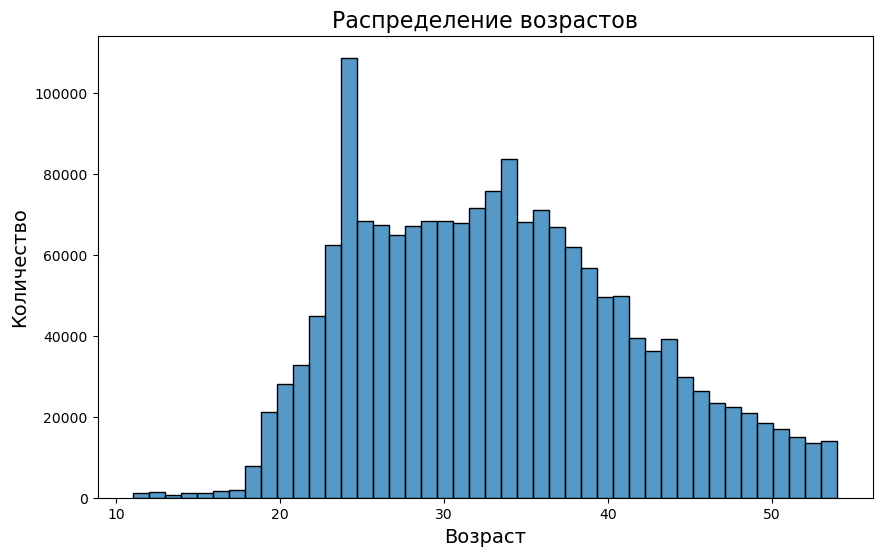

In [33]:
# Линейка
bins = te.age.nunique()

# Построение гистограммы с возраста пользователей
plt.figure(figsize=(10, 6))
sns.histplot(te['age'], bins=bins, kde=False)

plt.title('Распределение возрастов', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество', fontsize=14)

plt.show()

In [34]:
# Да ладно! Столь многим из вас по 24 года? Может, вы массово указали "18" лет в профиле шесть лет назад, да так и оставили?
# Интересно

In [35]:
te.sex.nunique()  # Есть только два гендера

2

In [36]:
te.sex.value_counts()  # Интересно. Женщины чаще обращаются либо чаще оставляют о себе данные

sex
female    1084515
male       675101
Name: count, dtype: int64

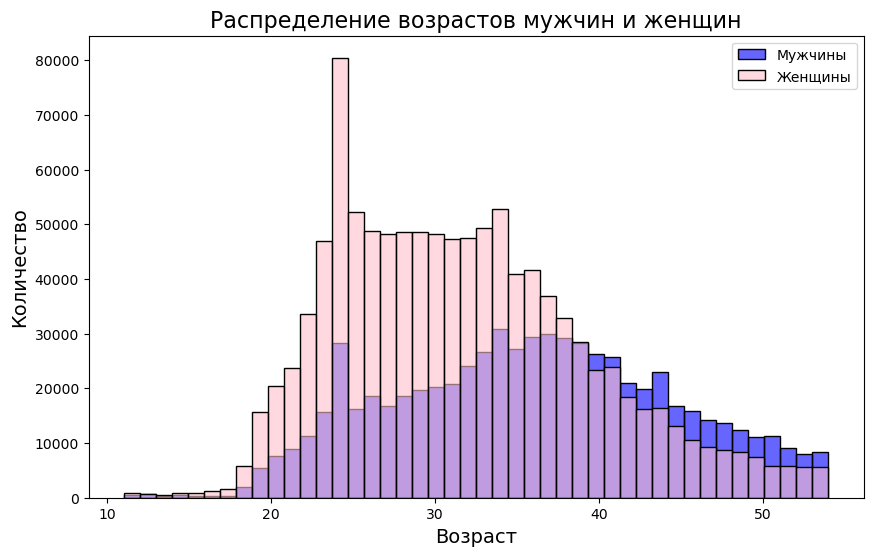

In [37]:
male_data = te[te['sex'] == 'male']
female_data = te[te['sex'] == 'female']

plt.figure(figsize=(10, 6))

# Гистограмма для мужчин (синий цвет)
sns.histplot(male_data['age'], bins=bins, color='blue', label='Мужчины', kde=False, alpha=0.6)
# Гистограмма для женщин (розовый цвет)
sns.histplot(female_data['age'], bins=bins, color='pink', label='Женщины', kde=False, alpha=0.6)

plt.legend()

plt.title('Распределение возрастов мужчин и женщин', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество', fontsize=14)

plt.show()

Хорошо, женщины моложе 40 лет представлены чаще. Но в группе пользователей старше 40 лет мужчин больше, чем женщин. Аномалия 24 лет сохранена в обеих группах.

In [38]:
# Посмотрим распределение возраста, но в пяти случайно взятых регионах
np.random.seed(42)  
five_regions = te['region'].unique()
random_five_regions = np.random.choice(five_regions, size=5, replace=False)
random_five_regions

array(['Yamalo-Nenets', 'Rostov', 'Kirov Oblast', 'Krasnoyarsk Krai',
       'Novosibirsk Oblast'], dtype=object)

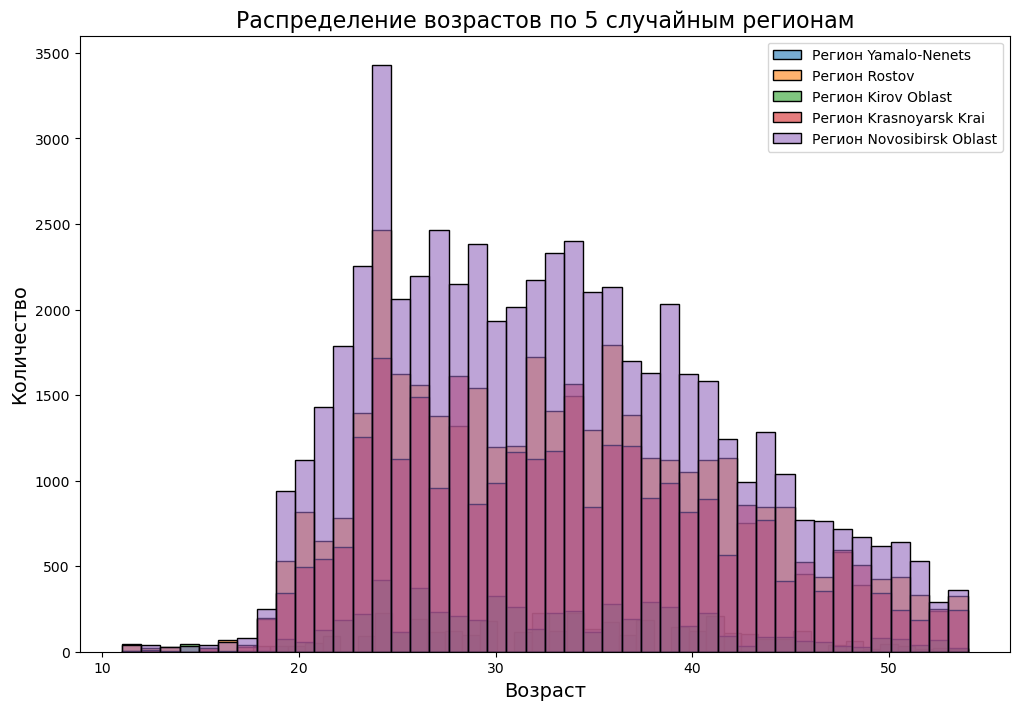

In [39]:
plt.figure(figsize=(12, 8))

for region in random_five_regions:
    region_data = te[te['region'] == region]  # Фильтруем данные по региону
    sns.histplot(region_data['age'], bins=bins, label=f'Регион {region}', kde=False, alpha=0.6)

plt.legend()

plt.title('Распределение возрастов по 5 случайным регионам', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество', fontsize=14)

plt.show()

Вроде бы мы не получили оснований считать, что регион проживания (или регистрации) как-то связан с возрастными особенностями. Ввиду ограниченности времени мы не будем это тестировать.


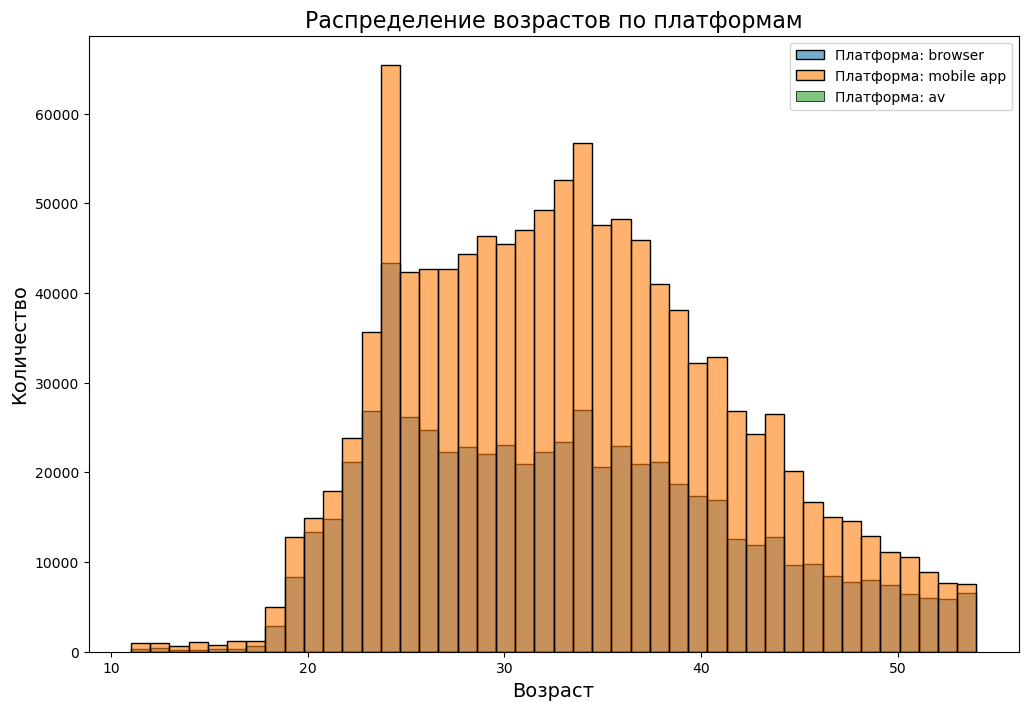

In [40]:
# Исследуем зависимость от платформы
platforms = te['ua_client_type'].unique()

plt.figure(figsize=(12, 8))

for platform in platforms:
    platform_data = te[te['ua_client_type'] == platform]  # Фильтруем данные по платформе
    sns.histplot(platform_data['age'], bins=bins, label=f'Платформа: {platform}', kde=False, alpha=0.6)

plt.legend()

plt.title('Распределение возрастов по платформам', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество', fontsize=14)

plt.show()

In [41]:
# Не видно разницы.
te.ua_client_type.value_counts()  # Забъём на av.

ua_client_type
mobile app    1140259
browser        619338
av                 19
Name: count, dtype: int64

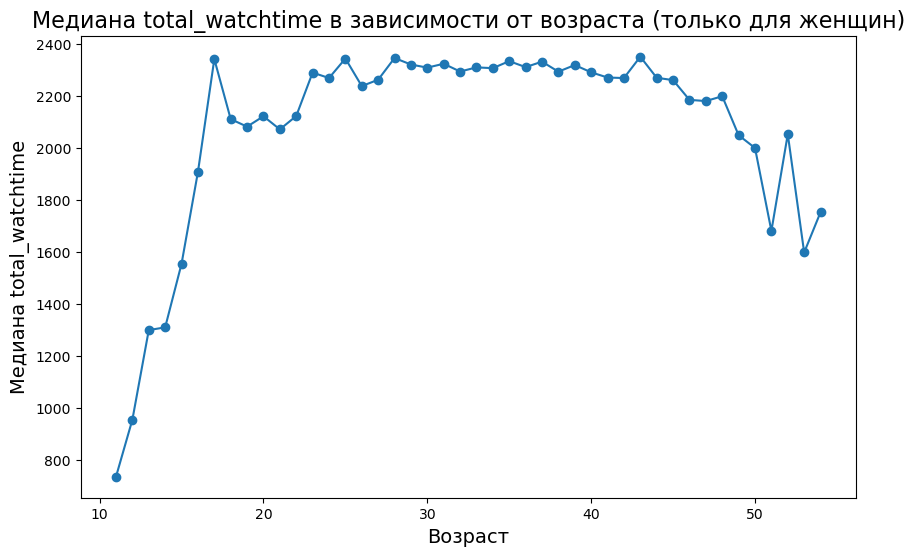

In [42]:
# Группируем данные по возрасту и вычисляем медиану для признака 'total_watchtime'
female_data = te[te['sex'] == 'female']

median_watchtime_by_age = female_data.groupby('age')['total_watchtime'].median()

plt.figure(figsize=(10, 6))
median_watchtime_by_age.plot(kind='line', marker='o')

plt.title('Медиана total_watchtime в зависимости от возраста (только для женщин)', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Медиана total_watchtime', fontsize=14)

plt.show()

In [43]:
# Переведём секунды в минуты
2200 / 60

36.666666666666664

In [44]:
# Что это? Одна серия сериала? 

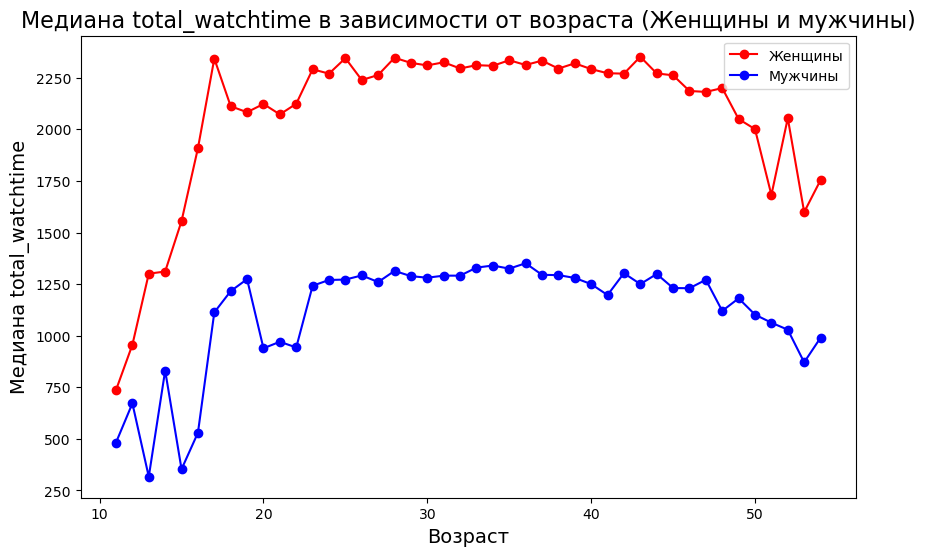

In [45]:
# Группируем данные по возрасту и вычисляем медиану для признака 'total_watchtime'
female_data = te[te['sex'] == 'female']
male_data = te[te['sex'] == 'male']

median_watchtime_by_age_female = female_data.groupby('age')['total_watchtime'].median()
median_watchtime_by_age_male = male_data.groupby('age')['total_watchtime'].median()

plt.figure(figsize=(10, 6))

median_watchtime_by_age_female.plot(kind='line', marker='o', color='red', label='Женщины')
median_watchtime_by_age_male.plot(kind='line', marker='o', color='blue', label='Мужчины')

plt.legend()

plt.title('Медиана total_watchtime в зависимости от возраста (Женщины и мужчины)', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Медиана total_watchtime', fontsize=14)

# Показать график
plt.show()

Ну а мужчины смотрят более короткие, 20-минутные видео. Те, кто младше 18, смотрят более короткие,и те, кто старге 40, имеют тенденцию к снижению длительности просматриваемого видео.

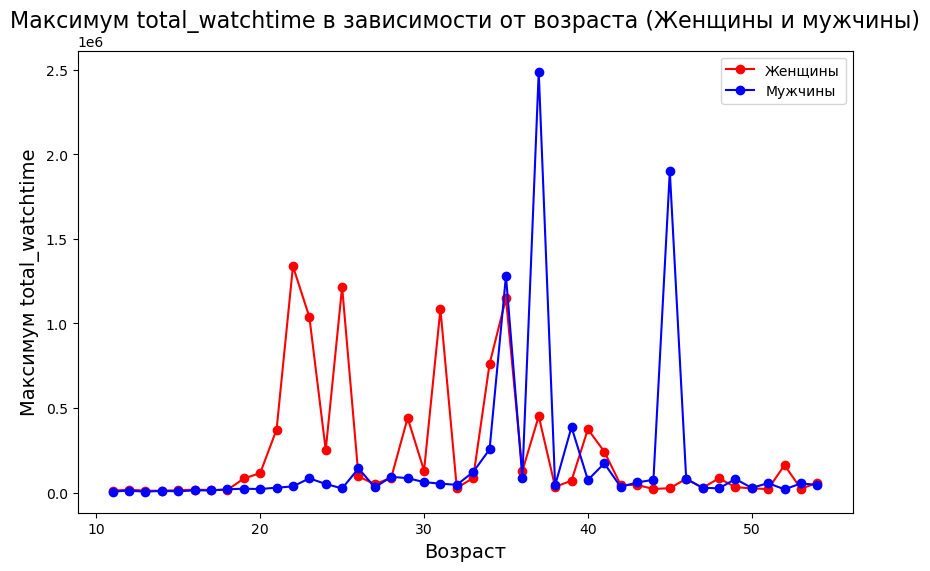

In [46]:
# Группируем данные по возрасту и вычисляем максимум для признака 'total_watchtime'
female_data = te[te['sex'] == 'female']
male_data = te[te['sex'] == 'male']

median_watchtime_by_age_female = female_data.groupby('age')['total_watchtime'].max()
median_watchtime_by_age_male = male_data.groupby('age')['total_watchtime'].max()

plt.figure(figsize=(10, 6))

median_watchtime_by_age_female.plot(kind='line', marker='o', color='red', label='Женщины')
median_watchtime_by_age_male.plot(kind='line', marker='o', color='blue', label='Мужчины')

plt.legend()

plt.title('Максимум total_watchtime в зависимости от возраста (Женщины и мужчины)', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Максимум total_watchtime', fontsize=14)

plt.show()

Так, кто-то не выключает рутуб на ночь. Либо транслирует музыку и уходит. Короче, выбросы

In [47]:
# Добавим число просмотров
viewer_uid_counts = te['viewer_uid'].value_counts().reset_index()
viewer_uid_counts.columns = ['viewer_uid', 'viewer_uid_views']  # Переименование столбцов
te = te.merge(viewer_uid_counts, on='viewer_uid', how='left')
te.head(2)

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,age,sex,age_class,viewer_uid_views
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,20,female,0,43
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,40,female,2,67


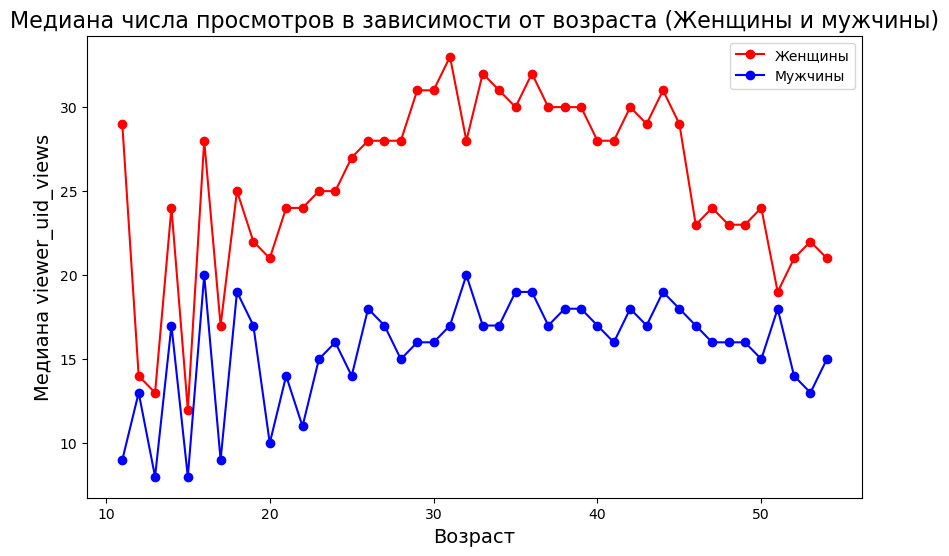

In [48]:
# Группируем данные по возрасту и вычисляем медиану для признака 'viewer_uid_views'
female_data = te[te['sex'] == 'female']
male_data = te[te['sex'] == 'male']

median_watchtime_by_age_female = female_data.groupby('age')['viewer_uid_views'].median()
median_watchtime_by_age_male = male_data.groupby('age')['viewer_uid_views'].median()

plt.figure(figsize=(10, 6))

median_watchtime_by_age_female.plot(kind='line', marker='o', color='red', label='Женщины')
median_watchtime_by_age_male.plot(kind='line', marker='o', color='blue', label='Мужчины')

plt.legend()

plt.title('Медиана числа просмотров в зависимости от возраста (Женщины и мужчины)', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Медиана viewer_uid_views', fontsize=14)

# Показать график
plt.show()

Ещё одна интересная особенность - количество просмотров суммарно растёт вместе с возрастом пользователя, и растёт примерно до 30-32 лет. Потом начинает потихоньку падать.

In [49]:
te.viewer_uid.value_counts()

viewer_uid
10940057    401
10012635    395
10013772    264
10061854    257
10013868    237
           ... 
10579533      1
10204557      1
10498444      1
10122979      1
10121498      1
Name: count, Length: 180012, dtype: int64

In [50]:
# Категории видео
vi.category.value_counts()  # Блин, разное. БЛИИИИН!

category
Разное                          141342
Сериалы                          49860
Телепередачи                     35510
Видеоигры                        33585
Музыка                           27295
Развлечения                      22506
Фильмы                           16579
Обучение                         13206
Лайфстайл                        12438
Юмор                             10281
Детям                            10227
Авто-мото                         8212
Аниме                             7504
Спорт                             7490
Интервью                          7115
Мультфильмы                       6374
Еда                               5788
Эзотерика                         5765
Путешествия                       5481
Технологии и интернет             5044
Хобби                             4744
Культура                          4301
Техника и оборудование            4223
Аудиокниги                        3880
Здоровье                          3518
Психология      

In [51]:
te = pd.merge(te, vi, on='rutube_video_id', how='left')
te['duration'] = te['duration'] / 1000

In [52]:
te

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,age,sex,age_class,viewer_uid_views,title,category,duration,author_id
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,20,female,0,43,Папа с особенностями. Мужское / Женское. Выпус...,Телепередачи,2456.534,1009219
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,40,female,2,67,Comedy Club: Мальдивы | Андрей Бебуришвили,Юмор,519.211,1006760
2,2024-06-01 21:30:43+03:00,St.-Petersburg,desktop,browser,Windows,Chrome,5647,video_96775,10894333,23,male,1,4,"Новая Битва экстрасенсов, 24 сезон, 11 выпуск",Телепередачи,5518.280,1009257
3,2024-06-01 23:03:42+03:00,Moscow,smartphone,mobile app,Android,Rutube,1521,video_161610,10029092,41,male,3,10,Сергей Орлов-снял дом!!!,Разное,1522.069,1058671
4,2024-06-01 22:48:09+03:00,Moscow,smartphone,mobile app,Android,Rutube,71,video_116245,10452976,38,female,2,33,Ищем сокровища в Полевском | Уральская Флоренц...,Путешествия,1249.920,1020020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759611,2024-06-30 17:08:36+03:00,Moscow,smartphone,mobile app,Android,Rutube,4230,video_162776,10026914,32,female,2,35,"Я знаю, но 1 сезон 3 серия",Сериалы,4480.915,1095392
1759612,2024-06-30 01:20:16+03:00,Moscow,smartphone,browser,Android,Firefox Mobile,382,video_316157,10417567,48,male,3,6,РЕАКЦИЯ ЮРИСТА НА TikTok | НЕАДЕКВАТНЫЕ СОТРУД...,Обучение,320.134,1033688
1759613,2024-06-30 22:37:04+03:00,St.-Petersburg,desktop,browser,Windows,Microsoft Edge,1342,video_83304,10009094,28,male,1,37,Свои чужие дети. Мужское / Женское. Выпуск от ...,Телепередачи,3125.675,1009219
1759614,2024-06-30 11:33:09+03:00,St.-Petersburg,smartphone,mobile app,Android,Rutube,801,video_132769,10574374,43,female,3,17,"Коля, Коля, Николай. Мужское / Женское. Выпуск...",Телепередачи,2401.283,1009219


In [53]:
# Видим глазами разницу между длительностью видео и временем собственно просмотра. Вычислим
te['duration_watched_proportion'] = te['total_watchtime'] / te['duration']
te.head(2)

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,age,sex,age_class,viewer_uid_views,title,category,duration,author_id,duration_watched_proportion
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,20,female,0,43,Папа с особенностями. Мужское / Женское. Выпус...,Телепередачи,2456.534,1009219,0.766527
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,40,female,2,67,Comedy Club: Мальдивы | Андрей Бебуришвили,Юмор,519.211,1006760,0.986112


In [54]:
te['duration_watched_proportion'].mean()  # Получется так, что видосы почти не смотрят. Чуточку покрутят, и выключат

0.6666551070790472

In [55]:
te['duration_watched_proportion'].max()  # И вообще никогда не досматривают? Странно

928.8616504854369

In [56]:
te.total_watchtime.min()  # По идее, видео можно выключить и через 5 секунд, если был миссклик.

31

In [57]:
te.total_watchtime.median()

1859.0

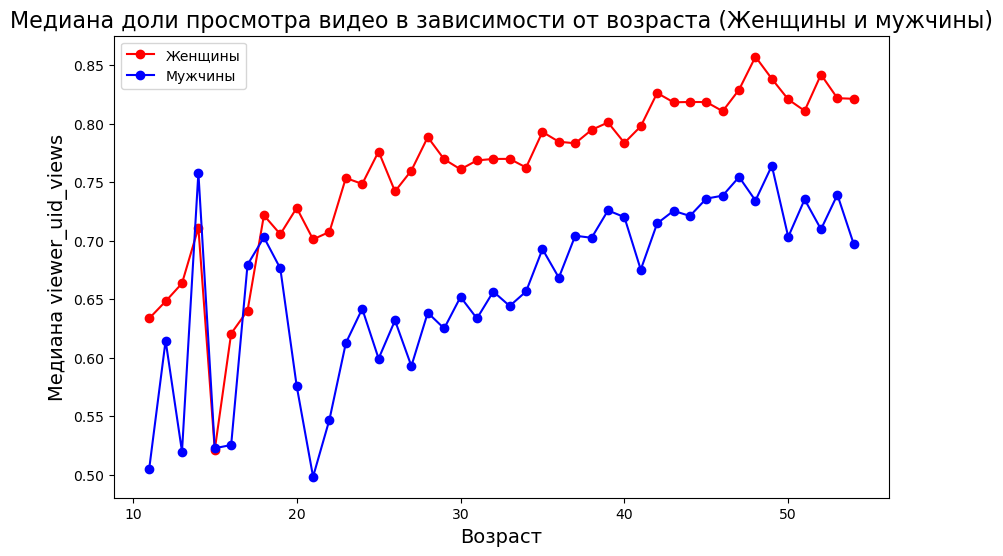

In [58]:
# Группируем данные по возрасту и вычисляем медиану для признака 'duration_watched_proportion' 
female_data = te[te['sex'] == 'female']
male_data = te[te['sex'] == 'male']

median_watchtime_by_age_female = female_data.groupby('age')['duration_watched_proportion'].median()
median_watchtime_by_age_male = male_data.groupby('age')['duration_watched_proportion'].median()

plt.figure(figsize=(10, 6))

median_watchtime_by_age_female.plot(kind='line', marker='o', color='red', label='Женщины')
median_watchtime_by_age_male.plot(kind='line', marker='o', color='blue', label='Мужчины')

plt.legend()

plt.title('Медиана доли просмотра видео в зависимости от возраста (Женщины и мужчины)', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Медиана viewer_uid_views', fontsize=14)

# Показать график
plt.show()

Женщины смотрят несколько внимательнее, и дольше не выключают видео

In [59]:
# Какие категории видео предпочитают?
most_common_categories_female = female_data['category'].value_counts()
most_common_categories_male = male_data['category'].value_counts()

In [60]:
# Преобразуем серии в DataFrame
df_female = most_common_categories_female.reset_index()
df_female.columns = ['category', 'female_count']  # Переименовываем столбцы

df_male = most_common_categories_male.reset_index()
df_male.columns = ['category', 'male_count']  # Переименовываем столбцы

# Объединяем DataFrame по категории
combined_categories = pd.merge(df_female, df_male, on='category', how='outer')
combined_categories

,category,female_count,male_count
0,Авто-мото,396,5209
1,Аниме,3562,9136
2,Аудио,186,430
3,Аудиокниги,333,1075
4,Бизнес и предпринимательство,1037,2201
5,Видеоигры,11803,21196
6,Детям,4995,6406
7,Дизайн,60,55
8,Еда,5215,9730
9,Животные,182,259


In [61]:
combined_categories['fem_proportion'] = combined_categories['female_count'] / len(female_data) 
combined_categories.head(2)  # Все женщины вообщее посмотрели некое количество видеороликов определённой категории.
# Рассчитаем количество роликов на одну женщину. Признак немного странный, но но позволит описать предпочтения пользователей

,category,female_count,male_count,fem_proportion
0,Авто-мото,396,5209,0.000365
1,Аниме,3562,9136,0.003284


In [62]:
combined_categories['mal_proportion'] = combined_categories['male_count'] / len(male_data) 
combined_categories.head(5)  # Вот так мы видим предпочтения.

,category,female_count,male_count,fem_proportion,mal_proportion
0,Авто-мото,396,5209,0.000365,0.007716
1,Аниме,3562,9136,0.003284,0.013533
2,Аудио,186,430,0.000172,0.000637
3,Аудиокниги,333,1075,0.000307,0.001592
4,Бизнес и предпринимательство,1037,2201,0.000956,0.003260


In [63]:
# Z-нормализованная фича 'gender_coef_category'
combined_categories['gender_coef_category'] = combined_categories['fem_proportion'] / combined_categories['mal_proportion']

mean_gender_coef = combined_categories['gender_coef_category'].mean()
std_gender_coef = combined_categories['gender_coef_category'].std()

combined_categories['gender_coef_category'] = (combined_categories['gender_coef_category'] - mean_gender_coef) / std_gender_coef
combined_categories

,category,female_count,male_count,fem_proportion,mal_proportion,gender_coef_category
0,Авто-мото,396,5209,0.000365,0.007716,-0.859092
1,Аниме,3562,9136,0.003284,0.013533,-0.401841
2,Аудио,186,430,0.000172,0.000637,-0.339674
3,Аудиокниги,333,1075,0.000307,0.001592,-0.518561
4,Бизнес и предпринимательство,1037,2201,0.000956,0.003260,-0.283453
5,Видеоигры,11803,21196,0.010883,0.031397,-0.158600
6,Детям,4995,6406,0.004606,0.009489,0.166113
7,Дизайн,60,55,0.000055,0.000081,0.619441
8,Еда,5215,9730,0.004809,0.014413,-0.189017
9,Животные,182,259,0.000168,0.000384,0.053885


In [64]:
te.head(2)

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,age,sex,age_class,viewer_uid_views,title,category,duration,author_id,duration_watched_proportion
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,20,female,0,43,Папа с особенностями. Мужское / Женское. Выпус...,Телепередачи,2456.534,1009219,0.766527
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,40,female,2,67,Comedy Club: Мальдивы | Андрей Бебуришвили,Юмор,519.211,1006760,0.986112


In [65]:
te = te.merge(combined_categories[['category', 'gender_coef_category']], 
              on='category', how='left')

In [66]:
te.head(2)

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,age,sex,age_class,viewer_uid_views,title,category,duration,author_id,duration_watched_proportion,gender_coef_category
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,20,female,0,43,Папа с особенностями. Мужское / Женское. Выпус...,Телепередачи,2456.534,1009219,0.766527,5.300926
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,40,female,2,67,Comedy Club: Мальдивы | Андрей Бебуришвили,Юмор,519.211,1006760,0.986112,-0.090461


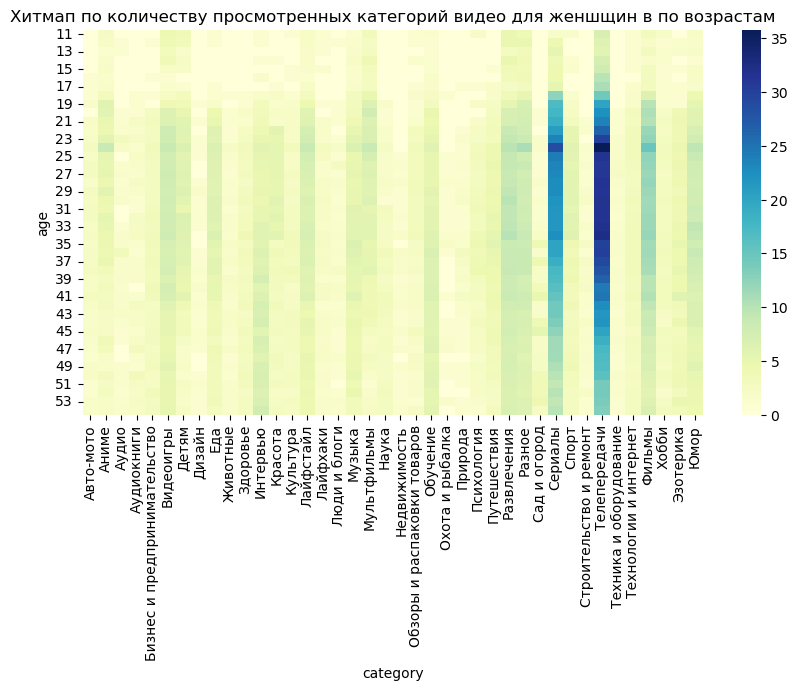

In [67]:
# Хитмап по количеству просмотренных категорий видео для женшщин
heatmap_data = female_data.pivot_table(index='age', columns='category', aggfunc='size', fill_value=0)

heatmap_data_sqrt = np.cbrt(heatmap_data)

plt.figure(figsize=(10, 5))  # Размер графика
sns.heatmap(heatmap_data_sqrt, cmap="YlGnBu", fmt='.1f')  # annot=True для отображения значений
plt.title("Хитмап по количеству просмотренных категорий видео для женшщин в по возрастам")
plt.show()

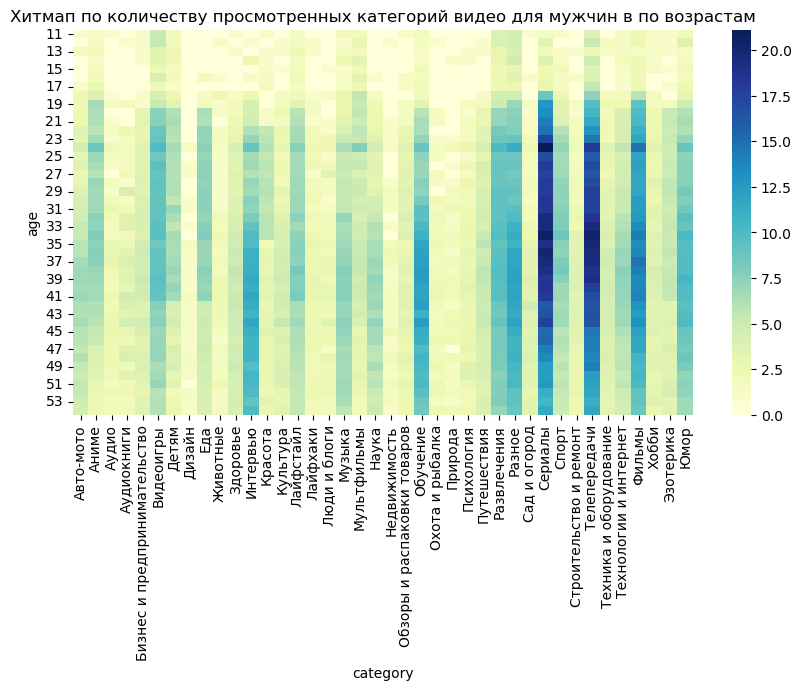

In [68]:
# Хитмап по количеству просмотренных категорий видео для мужчин
heatmap_data = male_data.pivot_table(index='age', columns='category', aggfunc='size', fill_value=0)

heatmap_data_sqrt = np.cbrt(heatmap_data)

plt.figure(figsize=(10, 5))  # Размер графика
sns.heatmap(heatmap_data_sqrt, cmap="YlGnBu", fmt='.1f')  # annot=True для отображения значений
plt.title("Хитмап по количеству просмотренных категорий видео для мужчин в по возрастам")
plt.show()

Получается так, что мужчины смотрят более разнообразный контент. Поэтому для определения пола можно будет использовать "gender_coef_category", а конкретно - его медианное значение

In [69]:
te.title.value_counts()  # Надо посмотреть, интересно стало.

title
Новая Битва экстрасенсов, 24 сезон, 11 выпуск                                                           23700
Новая Битва экстрасенсов, 24 сезон, 13 выпуск                                                           23255
Новая Битва экстрасенсов, 24 сезон, 12 выпуск                                                           23070
Выжить в Дубае. Возвращение, 1 выпуск                                                                   18853
Сокровища императора, 12 выпуск                                                                         16981
                                                                                                        ...  
⚡Гриффит- Гордый король [AMV]⚡                                                                              1
ОСТРЫЕ КРЫЛЬЯ И ВАШИ ВОПРОСЫ!                                                                               1
Большие стройки России: новый импульс развитию с помощью ГЭС                                                1
Топ-

In [70]:
titles = te[['viewer_uid', 'age', 'sex', 'rutube_video_id', 'title']]
titles

,viewer_uid,age,sex,rutube_video_id,title
0,10067243,20,female,video_133074,Папа с особенностями. Мужское / Женское. Выпус...
1,10245341,40,female,video_362960,Comedy Club: Мальдивы | Андрей Бебуришвили
2,10894333,23,male,video_96775,"Новая Битва экстрасенсов, 24 сезон, 11 выпуск"
3,10029092,41,male,video_161610,Сергей Орлов-снял дом!!!
4,10452976,38,female,video_116245,Ищем сокровища в Полевском | Уральская Флоренц...
...,...,...,...,...,...
1759611,10026914,32,female,video_162776,"Я знаю, но 1 сезон 3 серия"
1759612,10417567,48,male,video_316157,РЕАКЦИЯ ЮРИСТА НА TikTok | НЕАДЕКВАТНЫЕ СОТРУД...
1759613,10009094,28,male,video_83304,Свои чужие дети. Мужское / Женское. Выпуск от ...
1759614,10574374,43,female,video_132769,"Коля, Коля, Николай. Мужское / Женское. Выпуск..."


In [71]:
titles['title'] = titles['title'].str.replace(r'[^a-zA-Zа-яА-ЯёЁ\s]', '', regex=True)
titles.head()

,viewer_uid,age,sex,rutube_video_id,title
0,10067243,20,female,video_133074,Папа с особенностями Мужское Женское Выпуск от
1,10245341,40,female,video_362960,Comedy Club Мальдивы Андрей Бебуришвили
2,10894333,23,male,video_96775,Новая Битва экстрасенсов сезон выпуск
3,10029092,41,male,video_161610,Сергей Орловснял дом
4,10452976,38,female,video_116245,Ищем сокровища в Полевском Уральская Флоренци...


In [72]:
# Сейчас будет эксплод. Пристегнитесь
titles['title'] = titles['title'].str.split()  # Разбиваем на слова
titles['title'] = titles['title'].apply(lambda x: [word.lower() for word in x if len(word) > 3][:3])  # Оставляем только первые три слова, так как не хватает памяти
titles = titles.explode('title')  # Взрываем
titles.head(15)

,viewer_uid,age,sex,rutube_video_id,title
0,10067243,20,female,video_133074,папа
0,10067243,20,female,video_133074,особенностями
0,10067243,20,female,video_133074,мужское
1,10245341,40,female,video_362960,comedy
1,10245341,40,female,video_362960,club
1,10245341,40,female,video_362960,мальдивы
2,10894333,23,male,video_96775,новая
2,10894333,23,male,video_96775,битва
2,10894333,23,male,video_96775,экстрасенсов
3,10029092,41,male,video_161610,сергей


In [73]:
titles.isnull().sum()  # Пропуски

viewer_uid           0
age                  0
sex                  0
rutube_video_id      0
title              695
dtype: int64

In [74]:
titles = titles.dropna(subset=['title'])

In [75]:
titles.isnull().sum()  # Теперь хорошо

viewer_uid         0
age                0
sex                0
rutube_video_id    0
title              0
dtype: int64

In [76]:
# Топ-500 слов для молодых зрительниц, (9, 20] (лет)
filtered_titles = titles[(titles['sex'] == 'female') & (titles['age'].between(11, 16))]

filtered_titles = filtered_titles[filtered_titles['title'].notna()]  # Убираем строки с NaN (если есть) после explode
filtered_titles = filtered_titles[filtered_titles['title'].str.len() > 3]  # Фильтруем слова, оставляя только те, которые длиннее 3 букв

all_words = filtered_titles['title'].tolist()  # Создаем список всех слов
word_counts = Counter(all_words)  # Подсчитываем частоту каждого слова

top_500_words = word_counts.most_common(500)  # Получаем 500 самых часто употребляемых слов
top_500_fem0 = pd.DataFrame(top_500_words, columns=['Word', 'Frequency'])  # Преобразуем в DataFrame для удобного отображения

# Проверяем результат
top_500_fem0

,Word,Frequency
0,битва,899
1,новая,728
2,экстрасенсов,692
3,мужское,596
4,сезон,487
...,...,...
495,эдисона,4
496,какашка,4
497,ведёт,4
498,детство,4


In [77]:
# Топ-500 слов для зрительниц, (20, 30] (лет)
filtered_titles = titles[(titles['sex'] == 'female') & (titles['age'].between(23, 28))]

filtered_titles = filtered_titles[filtered_titles['title'].notna()]  # Убираем строки с NaN (если есть) после explode
filtered_titles = filtered_titles[filtered_titles['title'].str.len() > 3]  # Фильтруем слова, оставляя только те, которые длиннее 3 букв

all_words = filtered_titles['title'].tolist()  # Создаем список всех слов
word_counts = Counter(all_words)  # Подсчитываем частоту каждого слова

top_500_words = word_counts.most_common(500)  # Получаем 500 самых часто употребляемых слов
top_500_fem1 = pd.DataFrame(top_500_words, columns=['Word', 'Frequency'])  # Преобразуем в DataFrame для удобного отображения

# Проверяем результат
top_500_fem1

,Word,Frequency
0,сезон,81201
1,мужское,50271
2,выпуск,39791
3,битва,35113
4,новая,30441
...,...,...
495,кумы,142
496,цикла,142
497,морские,141
498,дьяволы,141


In [78]:
# Топ-500 слов для зрительниц, (30, 40] (лет)
filtered_titles = titles[(titles['sex'] == 'female') & (titles['age'].between(33, 38))]

filtered_titles = filtered_titles[filtered_titles['title'].notna()]  # Убираем строки с NaN (если есть) после explode
filtered_titles = filtered_titles[filtered_titles['title'].str.len() > 3]  # Фильтруем слова, оставляя только те, которые длиннее 3 букв

all_words = filtered_titles['title'].tolist()  # Создаем список всех слов
word_counts = Counter(all_words)  # Подсчитываем частоту каждого слова

top_500_words = word_counts.most_common(500)  # Получаем 500 самых часто употребляемых слов
top_500_fem2 = pd.DataFrame(top_500_words, columns=['Word', 'Frequency'])  # Преобразуем в DataFrame для удобного отображения

# Проверяем результат
top_500_fem2

,Word,Frequency
0,сезон,49505
1,мужское,42680
2,выпуск,37064
3,битва,25957
4,новая,22481
...,...,...
495,vikings,128
496,шаловливая,127
497,сергей,127
498,анархии,127


In [79]:
# Топ-500 слов для зрительниц, (40, 60] (лет)
filtered_titles = titles[(titles['sex'] == 'female') & (titles['age'].between(45, 46))]

filtered_titles = filtered_titles[filtered_titles['title'].notna()]  # Убираем строки с NaN (если есть) после explode
filtered_titles = filtered_titles[filtered_titles['title'].str.len() > 3]  # Фильтруем слова, оставляя только те, которые длиннее 3 букв

all_words = filtered_titles['title'].tolist()  # Создаем список всех слов
word_counts = Counter(all_words)  # Подсчитываем частоту каждого слова

top_500_words = word_counts.most_common(500)  # Получаем 500 самых часто употребляемых слов
top_500_fem3 = pd.DataFrame(top_500_words, columns=['Word', 'Frequency'])  # Преобразуем в DataFrame для удобного отображения

# Проверяем результат
top_500_fem3

,Word,Frequency
0,мужское,3257
1,сезон,3197
2,выпуск,3053
3,битва,2568
4,новая,2284
...,...,...
495,сгоревшие,17
496,мамин,17
497,отказник,17
498,приемные,17


In [80]:
# Топ-500 слов для молодых зрителей, (9, 20] (лет)
filtered_titles = titles[(titles['sex'] == 'male') & (titles['age'].between(11, 16))]

filtered_titles = filtered_titles[filtered_titles['title'].notna()]  # Убираем строки с NaN (если есть) после explode
filtered_titles = filtered_titles[filtered_titles['title'].str.len() > 3]  # Фильтруем слова, оставляя только те, которые длиннее 3 букв

all_words = filtered_titles['title'].tolist()  # Создаем список всех слов
word_counts = Counter(all_words)  # Подсчитываем частоту каждого слова

top_500_words = word_counts.most_common(500)  # Получаем 500 самых часто употребляемых слов
top_500_mal0 = pd.DataFrame(top_500_words, columns=['Word', 'Frequency'])  # Преобразуем в DataFrame для удобного отображения

# Проверяем результат
top_500_mal0

,Word,Frequency
0,сезон,163
1,серия,115
2,битва,90
3,новая,87
4,экстрасенсов,74
...,...,...
495,моря,3
496,семье,3
497,тирана,3
498,начинающая,3


In [81]:
# Топ-500 слов для зрителей, (20, 30] (лет)
filtered_titles = titles[(titles['sex'] == 'male') & (titles['age'].between(23, 28))]

filtered_titles = filtered_titles[filtered_titles['title'].notna()]  # Убираем строки с NaN (если есть) после explode
filtered_titles = filtered_titles[filtered_titles['title'].str.len() > 3]  # Фильтруем слова, оставляя только те, которые длиннее 3 букв

all_words = filtered_titles['title'].tolist()  # Создаем список всех слов
word_counts = Counter(all_words)  # Подсчитываем частоту каждого слова

top_500_words = word_counts.most_common(500)  # Получаем 500 самых часто употребляемых слов
top_500_mal1 = pd.DataFrame(top_500_words, columns=['Word', 'Frequency'])  # Преобразуем в DataFrame для удобного отображения

# Проверяем результат
top_500_mal1

,Word,Frequency
0,сезон,29436
1,серия,14017
2,выпуск,7095
3,сериал,5899
4,битва,5193
...,...,...
495,дьяволы,95
496,кунгфу,94
497,начальник,94
498,будущего,94


In [82]:
filtered_titles.viewer_uid.nunique()

15347

In [83]:
# Топ-500 слов для зрителей, (30, 40] (лет)
filtered_titles = titles[(titles['sex'] == 'male') & (titles['age'].between(33, 38))]

filtered_titles = filtered_titles[filtered_titles['title'].notna()]  # Убираем строки с NaN (если есть) после explode
filtered_titles = filtered_titles[filtered_titles['title'].str.len() > 3]  # Фильтруем слова, оставляя только те, которые длиннее 3 букв

all_words = filtered_titles['title'].tolist()  # Создаем список всех слов
word_counts = Counter(all_words)  # Подсчитываем частоту каждого слова

top_500_words = word_counts.most_common(500)  # Получаем 500 самых часто употребляемых слов
top_500_mal2 = pd.DataFrame(top_500_words, columns=['Word', 'Frequency'])  # Преобразуем в DataFrame для удобного отображения

# Проверяем результат
top_500_mal2

,Word,Frequency
0,сезон,32973
1,серия,18489
2,выпуск,14046
3,сериал,8863
4,битва,6167
...,...,...
495,кучера,146
496,породы,146
497,деньги,145
498,бойцовской,145


In [84]:
# Топ-500 слов для зрительниц, (40, 60] (лет)
filtered_titles = titles[(titles['sex'] == 'male') & (titles['age'].between(45, 46))]

filtered_titles = filtered_titles[filtered_titles['title'].notna()]  # Убираем строки с NaN (если есть) после explode
filtered_titles = filtered_titles[filtered_titles['title'].str.len() > 3]  # Фильтруем слова, оставляя только те, которые длиннее 3 букв

all_words = filtered_titles['title'].tolist()  # Создаем список всех слов
word_counts = Counter(all_words)  # Подсчитываем частоту каждого слова

top_500_words = word_counts.most_common(500)  # Получаем 500 самых часто употребляемых слов
top_500_mal3 = pd.DataFrame(top_500_words, columns=['Word', 'Frequency'])  # Преобразуем в DataFrame для удобного отображения

# Проверяем результат
top_500_mal3

,Word,Frequency
0,сезон,4684
1,серия,2741
2,выпуск,1692
3,сериал,1243
4,фильм,997
...,...,...
495,розы,29
496,беглые,29
497,юриста,29
498,tiktok,29


In [85]:
# Конкатенируем
dataframes = [top_500_fem0, top_500_fem1, top_500_fem2, top_500_fem3]
top_500_fem = pd.concat(dataframes, axis=1, ignore_index=True)
top_500_fem.columns = ['top_fem0_words', 'fem0_counts', 'top_fem1_words', 'fem1_counts', 'top_fem2_words', 'fem2_counts', 'top_fem3_words', 'fem3_counts']
top_500_fem

,top_fem0_words,fem0_counts,top_fem1_words,fem1_counts,top_fem2_words,fem2_counts,top_fem3_words,fem3_counts
0,битва,899,сезон,81201,сезон,49505,мужское,3257
1,новая,728,мужское,50271,мужское,42680,сезон,3197
2,экстрасенсов,692,выпуск,39791,выпуск,37064,выпуск,3053
3,мужское,596,битва,35113,битва,25957,битва,2568
4,сезон,487,новая,30441,новая,22481,новая,2284
...,...,...,...,...,...,...,...,...
495,эдисона,4,кумы,142,vikings,128,сгоревшие,17
496,какашка,4,цикла,142,шаловливая,127,мамин,17
497,ведёт,4,морские,141,сергей,127,отказник,17
498,детство,4,дьяволы,141,анархии,127,приемные,17


In [86]:
# Конкатенируем зрителей также
dataframes = [top_500_mal0, top_500_mal1, top_500_mal2, top_500_mal3]
top_500_mal = pd.concat(dataframes, axis=1, ignore_index=True)
top_500_mal.columns = ['top_mal0_words', 'mal0_counts', 'top_mal1_words', 'mal1_counts', 'top_mal2_words', 'mal2_counts', 'top_mal3_words', 'mal3_counts']
top_500_mal

,top_mal0_words,mal0_counts,top_mal1_words,mal1_counts,top_mal2_words,mal2_counts,top_mal3_words,mal3_counts
0,сезон,163,сезон,29436,сезон,32973,сезон,4684
1,серия,115,серия,14017,серия,18489,серия,2741
2,битва,90,выпуск,7095,выпуск,14046,выпуск,1692
3,новая,87,сериал,5899,сериал,8863,сериал,1243
4,экстрасенсов,74,битва,5193,битва,6167,фильм,997
...,...,...,...,...,...,...,...,...
495,моря,3,дьяволы,95,кучера,146,розы,29
496,семье,3,кунгфу,94,породы,146,беглые,29
497,тирана,3,начальник,94,деньги,145,юриста,29
498,начинающая,3,будущего,94,бойцовской,145,tiktok,29


In [87]:
# Ищем уникальные слова в каждом столбце
words_fem0 = set(top_500_fem['top_fem0_words'])
words_fem1 = set(top_500_fem['top_fem1_words'])
words_fem2 = set(top_500_fem['top_fem2_words'])
words_fem3 = set(top_500_fem['top_fem3_words'])
words_mal0 = set(top_500_mal['top_mal0_words'])
words_mal1 = set(top_500_mal['top_mal1_words'])
words_mal2 = set(top_500_mal['top_mal2_words'])
words_mal3 = set(top_500_mal['top_mal3_words'])

In [88]:
# Ищем уникальные слова для каждого множества

unique_fem0 = words_fem0 - (words_fem1 | words_fem2 | words_fem3 | words_mal0 | words_mal1 | words_mal2 | words_mal3)
unique_fem1 = words_fem1 - (words_fem0 | words_fem2 | words_fem3 | words_mal0 | words_mal1 | words_mal2 | words_mal3)
unique_fem2 = words_fem2 - (words_fem0 | words_fem1 | words_fem3 | words_mal0 | words_mal1 | words_mal2 | words_mal3)
unique_fem3 = words_fem3 - (words_fem0 | words_fem1 | words_fem2 | words_mal0 | words_mal1 | words_mal2 | words_mal3)

unique_mal0 = words_mal0 - (words_fem0 | words_fem1 | words_fem2 | words_fem3 | words_mal1 | words_mal2 | words_mal3)
unique_mal1 = words_mal1 - (words_fem0 | words_fem1 | words_fem2 | words_fem3 | words_mal0 | words_mal2 | words_mal3)
unique_mal2 = words_mal2 - (words_fem0 | words_fem1 | words_fem2 | words_fem3 | words_mal0 | words_mal1 | words_mal3)
unique_mal3 = words_mal3 - (words_fem0 | words_fem1 | words_fem2 | words_fem3 | words_mal0 | words_mal1 | words_mal2)

# Теперь можно проверить уникальные слова для каждого множества
print("Уникальные слова для fem0:", unique_fem0)
print("Уникальные слова для fem1:", unique_fem1)
print("Уникальные слова для fem2:", unique_fem2)
print("Уникальные слова для fem3:", unique_fem3)
print("Уникальные слова для mal0:", unique_mal0)
print("Уникальные слова для mal1:", unique_mal1)
print("Уникальные слова для mal2:", unique_mal2)
print("Уникальные слова для mal3:", unique_mal3)

Уникальные слова для fem0: {'gacha', 'прятки', 'личная', 'нашла', 'avatar', 'demon', 'выжил', 'приветом', 'inside', 'новогодний', 'силачка', 'анастасия', 'самородки', 'цвета', 'елены', 'инмт', 'питомец', 'горе', 'пробуем', 'переписка', 'султан', 'ангелины', 'проверка', 'призвали', 'валера', 'meme', 'сказочный', 'рапунцель', 'эдисона', 'похищение', 'корги', 'свинка', 'свою', 'египтус', 'radio', 'команда', 'вселенные', 'нашего', 'доме', 'живой', 'тренд', 'стали', 'цветам', 'сказка', 'уэнсдэй', 'скупаю', 'ночевка', 'рождения', 'учим', 'отношения', 'коля', 'запутанная', 'красавица', 'страшная', 'лайф', 'ягодок', 'нельзя', 'отдаю', 'стич', 'ивановых', 'видели', 'экстремальные', 'рецепта', 'энканто', 'ырка', 'коко', 'моко', 'божественного', 'будь', 'триггеры', 'нравятся', 'типы', 'живу', 'застряли', 'токсичные', 'стала', 'лёгкая', 'цветочки', 'ровные', 'елена', 'какашка', 'зверополис', 'одноклассницей', 'холодное', 'играю', 'улыбка', 'покоряет', 'приручить', 'last', 'который', 'бумаги', 'дра

In [89]:
unique_fem0

{'airbender',
 'avatar',
 'demon',
 'gacha',
 'inside',
 'last',
 'legend',
 'meme',
 'radio',
 'steam',
 'tapok',
 'undertale',
 'wanted',
 'анастасия',
 'ангелины',
 'аудио',
 'блуперсы',
 'богу',
 'божественного',
 'будь',
 'бумаги',
 'валера',
 'ведёт',
 'верность',
 'вернулась',
 'вечная',
 'видели',
 'влада',
 'влог',
 'вселенные',
 'выжил',
 'гадкий',
 'гача',
 'горе',
 'девять',
 'доме',
 'дракона',
 'драконы',
 'дружба',
 'евангелион',
 'египтус',
 'елена',
 'елены',
 'живой',
 'животных',
 'живу',
 'задание',
 'запутанная',
 'застряли',
 'зверополис',
 'звздная',
 'зубки',
 'ивановых',
 'играю',
 'имени',
 'инмт',
 'какашка',
 'карт',
 'коко',
 'коля',
 'команда',
 'комнаты',
 'корги',
 'кота',
 'который',
 'кошмар',
 'красавица',
 'краснею',
 'куклы',
 'лайф',
 'лило',
 'личная',
 'лолита',
 'лёгкая',
 'математике',
 'меме',
 'мечты',
 'миров',
 'моко',
 'наркомания',
 'нашего',
 'нашла',
 'нельзя',
 'непослушный',
 'новогодний',
 'ночевка',
 'нравятся',
 'обречен',
 'однокл

Вот и всё, заканчиваем EDA, и переходим к фичаинженерингу

# Feature Engineering

In [90]:
temp = te.copy()  # Бэкап, если что-то пойдёт не так.

In [91]:
# te = temp.copy()  # вернём из бэкапа, если хотим пересчитать

In [92]:
te.columns

Index(['event_timestamp', 'region', 'ua_device_type', 'ua_client_type',
       'ua_os', 'ua_client_name', 'total_watchtime', 'rutube_video_id',
       'viewer_uid', 'age', 'sex', 'age_class', 'viewer_uid_views', 'title',
       'category', 'duration', 'author_id', 'duration_watched_proportion',
       'gender_coef_category'],
      dtype='object')

Итак, есть датасет te. По причинам недостатка времени для анализа и также по причине непонятной пока связи с целевыми переменными, либо по причине преобразования в другие фичи мы решили сразу исключить из анализа такие признаки, как:

'event_timestamp', 'region', 'ua_device_type', 'ua_client_type', 'ua_os', 'ua_client_name', 'author_id', 'category'

Мы преобразовали 'category' в 'gender_coef_category'. Признак 'title' подвергся процессингу, и превратился в 8 множеств, которые надо внедрить в финальный датасет по типу one-hot encoding, но при использовании 'title', который будет удалён после внедрения множеств.

Для каждого viewer_uid будут рассчитаны медианы следующих признаков:

'total_watchtime', 'duration', 'duration_watched_proportion' и 'gender_coef_category'. Исходные признаки потом будут удалены.

Значения признака 'sex' будут перекодированы в 0 и 1 ('мужчина' и 'женщина').

In [93]:
te = te.drop(columns={'event_timestamp', 'region', 'ua_device_type', 'ua_client_type', 'ua_os', 'ua_client_name', 'author_id', 'category'}, axis=1)
te.head(2)

,total_watchtime,rutube_video_id,viewer_uid,age,sex,age_class,viewer_uid_views,title,duration,duration_watched_proportion,gender_coef_category
0,1883,video_133074,10067243,20,female,0,43,Папа с особенностями. Мужское / Женское. Выпус...,2456.534,0.766527,5.300926
1,512,video_362960,10245341,40,female,2,67,Comedy Club: Мальдивы | Андрей Бебуришвили,519.211,0.986112,-0.090461


In [94]:
te['total_watchtime_mean'] = te.groupby('viewer_uid')['total_watchtime'].transform('median')
te['duration_mean'] = te.groupby('viewer_uid')['duration'].transform('median')
te['duration_watched_proportion_mean'] = te.groupby('viewer_uid')['duration_watched_proportion'].transform('median')
te['gender_coef_category_mean'] = te.groupby('viewer_uid')['gender_coef_category'].transform('median')
te.head(2)

,total_watchtime,rutube_video_id,viewer_uid,age,sex,age_class,viewer_uid_views,title,duration,duration_watched_proportion,gender_coef_category,total_watchtime_mean,duration_mean,duration_watched_proportion_mean,gender_coef_category_mean
0,1883,video_133074,10067243,20,female,0,43,Папа с особенностями. Мужское / Женское. Выпус...,2456.534,0.766527,5.300926,2450.0,2752.040,0.984091,5.300926
1,512,video_362960,10245341,40,female,2,67,Comedy Club: Мальдивы | Андрей Бебуришвили,519.211,0.986112,-0.090461,2397.0,2968.047,0.980782,5.300926


In [95]:
te = te.drop(columns={'total_watchtime', 'duration', 'duration_watched_proportion', 'gender_coef_category'}, axis=1)
te.head(2)

,rutube_video_id,viewer_uid,age,sex,age_class,viewer_uid_views,title,total_watchtime_mean,duration_mean,duration_watched_proportion_mean,gender_coef_category_mean
0,video_133074,10067243,20,female,0,43,Папа с особенностями. Мужское / Женское. Выпус...,2450.0,2752.040,0.984091,5.300926
1,video_362960,10245341,40,female,2,67,Comedy Club: Мальдивы | Андрей Бебуришвили,2397.0,2968.047,0.980782,5.300926


In [96]:
te

,rutube_video_id,viewer_uid,age,sex,age_class,viewer_uid_views,title,total_watchtime_mean,duration_mean,duration_watched_proportion_mean,gender_coef_category_mean
0,video_133074,10067243,20,female,0,43,Папа с особенностями. Мужское / Женское. Выпус...,2450.0,2752.0400,0.984091,5.300926
1,video_362960,10245341,40,female,2,67,Comedy Club: Мальдивы | Андрей Бебуришвили,2397.0,2968.0470,0.980782,5.300926
2,video_96775,10894333,23,male,1,4,"Новая Битва экстрасенсов, 24 сезон, 11 выпуск",5551.0,5484.4600,1.007911,5.300926
3,video_161610,10029092,41,male,3,10,Сергей Орлов-снял дом!!!,1494.5,1512.8035,0.989159,-0.343425
4,video_116245,10452976,38,female,2,33,Ищем сокровища в Полевском | Уральская Флоренц...,671.0,2957.8800,0.508388,5.300926
...,...,...,...,...,...,...,...,...,...,...,...
1759611,video_162776,10026914,32,female,2,35,"Я знаю, но 1 сезон 3 серия",2602.0,3580.3530,0.875520,1.052632
1759612,video_316157,10417567,48,male,3,6,РЕАКЦИЯ ЮРИСТА НА TikTok | НЕАДЕКВАТНЫЕ СОТРУД...,362.0,374.8090,0.987167,0.285440
1759613,video_83304,10009094,28,male,1,37,Свои чужие дети. Мужское / Женское. Выпуск от ...,2481.0,3272.0000,0.826683,5.300926
1759614,video_132769,10574374,43,female,3,17,"Коля, Коля, Николай. Мужское / Женское. Выпуск...",4212.0,5513.9600,0.901593,5.300926


In [97]:
# Функция для проверки наличия слова из title в unique_fem0
def check_unique_fem0(title):
    if pd.isna(title):  # Если title отсутствует
        return 0
    # Разбиваем title на слова, переводим в нижний регистр, фильтруем по длине
    words = [word.lower() for word in title.split() if len(word) > 3]
    # Проверяем, если хотя бы одно слово есть в unique_fem0
    return 1 if any(word in unique_fem0 for word in words) else 0

# Применяем функцию к колонке 'title' и создаём новую колонку 'unique_fem0'
te['unique_fem0'] = te['title'].apply(check_unique_fem0)

In [98]:
te[te['age'] == 15].unique_fem0.value_counts()

unique_fem0
0    921
1    130
Name: count, dtype: int64

In [99]:
te[te['age'] == 26].unique_fem0.value_counts()  # Слабое место метода - слова всё же не совсем уникальны.
# Мы взяли топ-100, мы взяли также первые три слова. Фактически, эти слова могли оказаться и в других выборках, просто в другом месте
# Или с меньшей частотой. Но будь что будет

unique_fem0
0    66410
1      953
Name: count, dtype: int64

In [100]:
te[te['age'] == 44].unique_fem0.value_counts() 

unique_fem0
0    38539
1      765
Name: count, dtype: int64

In [101]:
te.head(12)

,rutube_video_id,viewer_uid,age,sex,age_class,viewer_uid_views,title,total_watchtime_mean,duration_mean,duration_watched_proportion_mean,gender_coef_category_mean,unique_fem0
0,video_133074,10067243,20,female,0,43,Папа с особенностями. Мужское / Женское. Выпус...,2450.0,2752.0400,0.984091,5.300926,0
1,video_362960,10245341,40,female,2,67,Comedy Club: Мальдивы | Андрей Бебуришвили,2397.0,2968.0470,0.980782,5.300926,0
2,video_96775,10894333,23,male,1,4,"Новая Битва экстрасенсов, 24 сезон, 11 выпуск",5551.0,5484.4600,1.007911,5.300926,0
3,video_161610,10029092,41,male,3,10,Сергей Орлов-снял дом!!!,1494.5,1512.8035,0.989159,-0.343425,0
4,video_116245,10452976,38,female,2,33,Ищем сокровища в Полевском | Уральская Флоренц...,671.0,2957.8800,0.508388,5.300926,0
5,video_61152,10013813,44,female,3,92,День защиты детей. Мужское / Женское. Выпуск о...,2430.5,2555.9340,0.993594,5.300926,0
6,video_53642,10058831,46,female,3,24,"Влюбись, если сможешь, 1 сезон, 14 выпуск",4113.0,4244.6600,0.982177,5.300926,0
7,video_114660,10084832,26,female,1,27,Сверхъестественное / Supernatural - 2 сезон 10...,2337.0,2466.0800,0.964769,1.052632,0
8,video_425474,10439246,22,male,1,59,Каменное сердце 1 сезон 5 серия,2620.0,3125.0250,0.922913,1.052632,0
9,video_241755,10090266,33,female,2,6,Волчата из Перми. Мужское / Женское. Выпуск от...,3875.5,3966.9845,0.959638,5.300926,0


In [ ]:
# Список всех множеств и их имён для создания колонок
unique_sets = [
    # ('unique_fem0', unique_fem0),
    ('unique_fem1', unique_fem1),
    ('unique_fem2', unique_fem2),
    ('unique_fem3', unique_fem3),
    ('unique_mal0', unique_mal0),
    ('unique_mal1', unique_mal1),
    ('unique_mal2', unique_mal2),
    ('unique_mal3', unique_mal3)
]

# Функция для проверки наличия слова из title в соответствующем множестве
def check_unique_words(title, word_set):
    if pd.isna(title):  # Если title отсутствует
        return 0
    # Разбиваем title на слова, переводим в нижний регистр, фильтруем по длине
    words = [word.lower() for word in title.split() if len(word) > 3]
    # Проверяем, если хотя бы одно слово есть в word_set
    return 1 if any(word in word_set for word in words) else 0

# Для каждого множества создаём отдельную колонку
for col_name, word_set in unique_sets:
    te[col_name] = te['title'].apply(lambda title: check_unique_words(title, word_set))

# Проверяем результат
print(te[['title'] + [col_name for col_name, _ in unique_sets]].head())

In [ ]:
te.info()

In [ ]:
te.describe()

In [ ]:
te.unique_fem0.mean(), te.unique_fem1.mean(), te.unique_fem2.mean(), te.unique_fem3.mean()

In [ ]:
te.head(2)

In [ ]:
te = te.drop(columns={'rutube_video_id', 'title'}, axis=1)

In [ ]:
te['sex'] = te['sex'].replace({'female': 0, 'male': 1})

In [ ]:
te.head(3)

In [ ]:
unique_fem0_count = te.groupby('age')['unique_fem0'].sum()

# Строим гистограмму
plt.figure(figsize=(10, 6))  # Размер графика
sns.barplot(x=unique_fem0_count.index, y=unique_fem0_count.values, palette="viridis")

# Настраиваем график
plt.title('Количество unique_fem0 для каждого возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество unique_fem0')
plt.xticks(rotation=45)  # Поворачиваем метки по оси x для удобства чтения

# Показываем график
plt.show()

In [ ]:
age_counts = te.groupby('age')['unique_fem0'].count()

# Подсчитываем количество уникальных значений unique_fem0 для каждого возраста
unique_fem0_count = te.groupby('age')['unique_fem0'].sum()

# Вычисляем процент
percent_unique_fem0 = (unique_fem0_count / age_counts) * 100

# Строим гистограмму
plt.figure(figsize=(10, 6))  # Размер графика
sns.barplot(x=percent_unique_fem0.index, y=percent_unique_fem0.values, palette="viridis")

# Настраиваем график
plt.title('Процент уникальных значений unique_fem0 для каждого возраста')
plt.xlabel('Возраст')
plt.ylabel('Процент unique_fem0')
plt.xticks(rotation=45)  # Поворачиваем метки по оси x для удобства чтения

# Показываем график
plt.show()

In [ ]:
age_counts = te.groupby('age')['unique_fem1'].count()

# Подсчитываем количество уникальных значений unique_fem0 для каждого возраста
unique_fem0_count = te.groupby('age')['unique_fem1'].sum()

# Вычисляем процент
percent_unique_fem0 = (unique_fem0_count / age_counts) * 100

# Строим гистограмму
plt.figure(figsize=(10, 6))  # Размер графика
sns.barplot(x=percent_unique_fem0.index, y=percent_unique_fem0.values, palette="viridis")

# Настраиваем график
plt.title('Процент уникальных значений ключевых слов для каждого возраста')
plt.xlabel('Возраст')
plt.ylabel('Процент unique_fem1')
plt.xticks(rotation=45)  # Поворачиваем метки по оси x для удобства чтения

# Показываем график
plt.show()

In [ ]:
age_counts = te.groupby('age')['unique_fem2'].count()

# Подсчитываем количество уникальных значений unique_fem0 для каждого возраста
unique_fem0_count = te.groupby('age')['unique_fem2'].sum()

# Вычисляем процент
percent_unique_fem0 = (unique_fem0_count / age_counts) * 100

# Строим гистограмму
plt.figure(figsize=(10, 6))  # Размер графика
sns.barplot(x=percent_unique_fem0.index, y=percent_unique_fem0.values, palette="viridis")

# Настраиваем график
plt.title('Процент распространения fem2-ассоциированных значений ключевых по всему датасету')
plt.xlabel('Возраст')
plt.ylabel('Процент unique_fem2')
plt.xticks(rotation=45)  # Поворачиваем метки по оси x для удобства чтения

# Показываем график
plt.show()

In [ ]:
age_counts = te.groupby('age')['unique_mal0'].count()

# Подсчитываем количество уникальных значений unique_fem0 для каждого возраста
unique_fem0_count = te.groupby('age')['unique_mal0'].sum()

# Вычисляем процент
percent_unique_fem0 = (unique_fem0_count / age_counts) * 100

# Строим гистограмму
plt.figure(figsize=(10, 6))  # Размер графика
sns.barplot(x=percent_unique_fem0.index, y=percent_unique_fem0.values, palette="viridis")

# Настраиваем график
plt.title('Процент распространения mal0-ассоциированных значений ключевых по всему датасету')
plt.xlabel('Возраст')
plt.ylabel('Процент unique_mal0')
plt.xticks(rotation=45)  # Поворачиваем метки по оси x для удобства чтения

# Показываем график
plt.show()

In [ ]:
age_counts = te.groupby('age')['unique_mal2'].count()

# Подсчитываем количество уникальных значений unique_fem0 для каждого возраста
unique_fem0_count = te.groupby('age')['unique_mal2'].sum()

# Вычисляем процент
percent_unique_fem0 = (unique_fem0_count / age_counts) * 100

# Строим гистограмму
plt.figure(figsize=(10, 6))  # Размер графика
sns.barplot(x=percent_unique_fem0.index, y=percent_unique_fem0.values, palette="viridis")

# Настраиваем график
plt.title('Процент распространения mal2-ассоциированных значений ключевых по всему датасету')
plt.xlabel('Возраст')
plt.ylabel('Процент unique_mal2')
plt.xticks(rotation=45)  # Поворачиваем метки по оси x для удобства чтения

# Показываем график
plt.show()

Самые интеренсые и разнообразные названия у видео, которые смотрят девочки до 11-12 лет. Взрослые уже не так заинтересованы.

Анализ мог бы быть получше, но не хватает мощностей.

In [ ]:
te.head(2)

In [ ]:
te.columns

In [ ]:
# Средние значения просматриваемых видео с интеренсыми словами в названиях
medians = te.groupby('viewer_uid')[['unique_fem0', 'unique_fem1', 'unique_fem2', 'unique_fem3', 
                                     'unique_mal0', 'unique_mal1', 'unique_mal2', 'unique_mal3']].mean()

medians.columns = ['avg_' + col for col in medians.columns]  # Переименуем столбцы, добавляя префикс 'median_' к каждому имени

te = te.merge(medians, on='viewer_uid', how='left')  # Объединим медианы с исходным DataFrame te

In [ ]:
te.head()

In [ ]:
# Удаляем указанные столбцы из DataFrame te
te = te.drop(columns=['unique_fem0', 'unique_fem1', 'unique_fem2', 'unique_fem3', 'unique_mal0', 'unique_mal1', 'unique_mal2', 'unique_mal3'])

In [ ]:
te.head()

In [ ]:
te.shape, te.viewer_uid.nunique()

In [ ]:
te = te.drop_duplicates(subset='viewer_uid', keep='first')
te.shape

In [ ]:
te.describe()

In [ ]:
te.isnull().sum()

In [ ]:
# Чисто! Переходим к обучению модели

In [ ]:
te.to_csv(dir + 'train_events_processed_and_featured.csv', index=False)

In [ ]:
# Но где мы проведём отсечку для обучения модели? Сколько просмотров должен сделать пользователь, чтобы было достаточно данных для анализа?

In [ ]:
te.viewer_uid_views.value_counts()

In [ ]:
# Получаем данные после value_counts() и берем первые 50 строк
viewer_uid_views_counts = te.viewer_uid_views.value_counts().head(50)

# Построение линейного графика по первым 50 строкам
plt.figure(figsize=(10, 6))
plt.plot(viewer_uid_views_counts.index, viewer_uid_views_counts.values, marker='o', linestyle='-', color='b')
plt.title('Line Plot of Viewer UID Views (Top 50)')
plt.xlabel('Viewer UID (Top 50)')
plt.ylabel('Number of Views')
plt.grid(True)
plt.show()

# Regression analysis for age_class prediction

In [ ]:
te = pd.read_csv(dir + 'train_events_processed_and_featured.csv')

In [ ]:
te.info()

In [ ]:
# Модификатор для отбора случаев по количеству просмотров
n = 6
te = te[te['viewer_uid_views'] >= n]
te.shape

In [ ]:
# Убираем пол 'sex'. Класс возраста остётся, но превратится в таргет
te = te.drop(columns=['sex', 'age'])

In [ ]:
corr_with_target = te.corr()['age_class'].abs().sort_values()

# удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('age_class')

# строим столбчатую диаграмму корреляций
plt.figure(figsize=(10, 5))
plt.bar(corr_with_target.index, corr_with_target.values)
plt.title('Корреляция с целевой переменной')
plt.xlabel('Признаки')
plt.ylabel('Коэффициент корреляции')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Y and X
y=te['age_class']
X=te.drop(columns=['age_class'])

In [ ]:
# Делим на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
# Стандартизуем
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Обучаем и используем
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_predict = lr_model.predict(X_train)  # Делаем предсказание для тренировочной выборки
y_test_predict = lr_model.predict(X_test)  # Делаем предсказание для тестовой выборки

print(f"Train R^2: {r2_score(y_train, y_train_predict)}")
print(f"Test R^2: {r2_score(y_test, y_test_predict)}")

In [ ]:
# Метрика F1
# Округляем предсказания до ближайших целых чисел
y_train_predict_rounded = y_train_predict.round().astype(int)
y_test_predict_rounded = y_test_predict.round().astype(int)

# Считаем F1-метрику для тренировочных данных
f1_train = f1_score(y_train, y_train_predict_rounded, average='weighted')

# Считаем F1-метрику для тестовых данных
f1_test = f1_score(y_test, y_test_predict_rounded, average='weighted')

print(f"Train F1 (weighted): {f1_train}")
print(f"Test F1 (weighted): {f1_test}")

In [ ]:
# Округляем предсказания до ближайших целых, чтобы они соответствовали классам
y_train_predict_rounded = y_train_predict.round().astype(int)
y_test_predict_rounded = y_test_predict.round().astype(int)

# Строим матрицу ошибок для тестовой выборки
conf_matrix = confusion_matrix(y_test, y_test_predict_rounded)

# Визуализируем матрицу ошибок с использованием ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=sorted(y.unique()))
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Настраиваем заголовок и метки осей
plt.title(f"Confusion Matrix for {n}-more views", fontsize=12)
plt.xlabel("Predicted Classes", fontsize=12)
plt.ylabel("True Classes", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()  # Убираем лишние отступы
plt.show()

print(f"Train R^2: {r2_score(y_train, y_train_predict)}")
print(f"Test R^2: {r2_score(y_test, y_test_predict)}")
print(f"Train F1 (weighted): {f1_train}")
print(f"Test F1 (weighted): {f1_test}")

# K-means gender prediction

In [ ]:
# Автоматическая классификация
results = []

# Перебор значений n от 1 до 20
for n in range(40):
    # Данные
    te = pd.read_csv(dir + 'train_events_processed_and_featured.csv')
    vid = te['viewer_uid']
    te = te[te['viewer_uid_views'] > n]

    # Удаляем ненужные столбцы

    te = te.drop(columns=['age', 'age_class', 'viewer_uid'])

    y = te['sex']
    X = te.drop(columns=['sex'])

    # Делим на трейн и тест
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    # Стандартизуем
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Определяем начальные центры кластеров
    num_clusters = len(np.unique(y_train))  # Число кластеров соответствует числу уникальных классов

    # Определение центров кластеров
    initial_centers = []
    for label in np.unique(y_train):
        initial_centers.append(X_train[y_train == label].mean(axis=0))

    # Преобразуем в массив NumPy
    initial_centers = np.array(initial_centers)

    # Обучаем модель KMeans с заданными центрами
    kmeans_model = KMeans(n_clusters=num_clusters, init=initial_centers, n_init=1, random_state=42)
    kmeans_model.fit(X_train)

    # Получаем предсказания кластеров
    y_train_predict = kmeans_model.predict(X_train)
    y_test_predict = kmeans_model.predict(X_test)

    # Сопоставляем кластеры с классами
    cluster_labels = pd.DataFrame({'cluster': y_train_predict, 'class': y_train})
    most_common_classes = cluster_labels.groupby('cluster')['class'].agg(lambda x: x.mode()[0]).reset_index()

    # Создаем словарь для быстрого сопоставления
    class_mapping = dict(zip(most_common_classes['cluster'], most_common_classes['class']))

    # Применяем сопоставление классов к предсказаниям
    y_test_mapped = np.vectorize(class_mapping.get)(y_test_predict)

    # Вычисляем F-score
    f_score = f1_score(y_test, y_test_mapped, average='weighted')

    # Для метрик R и R^2
    y_test_numeric = (y_test == 1).astype(int)  # Преобразуем в бинарный вид
    y_test_mapped_numeric = (y_test_mapped == 1).astype(int)  # Преобразуем предсказания в бинарный вид

    # Вычисляем R^2
    r2 = r2_score(y_test_numeric, y_test_mapped_numeric)

    # Сохраняем результаты
    results.append({'n': n, 'F1 Score': f_score, 'R^2': r2})

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)

# Выводим результаты
results_df

In [ ]:
# Модификатор для отбора случаев по количеству просмотров
n = 7

# Данные
te = pd.read_csv(dir + 'train_events_processed_and_featured.csv')
te = te[te['viewer_uid_views'] >= n]

# Удаляем ненужные столбцы
te = te.drop(columns=['age', 'age_class', 'viewer_uid'])

y = te['sex']
X = te.drop(columns=['sex'])

# Делим на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

# Стандартизуем
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Определяем начальные центры кластеров
num_clusters = len(np.unique(y_train))  # Число кластеров соответствует числу уникальных классов

# Определение центров кластеров
initial_centers = []
for label in np.unique(y_train):
    initial_centers.append(X_train[y_train == label].mean(axis=0))

# Преобразуем в массив NumPy
initial_centers = np.array(initial_centers)

# Обучаем модель KMeans с заданными центрами
kmeans_model = KMeans(n_clusters=num_clusters, init=initial_centers, n_init=1, random_state=42)
kmeans_model.fit(X_train)

# Получаем предсказания кластеров
y_train_predict = kmeans_model.predict(X_train)
y_test_predict = kmeans_model.predict(X_test)

# Сопоставляем кластеры с классами
cluster_labels = pd.DataFrame({'cluster': y_train_predict, 'class': y_train})
most_common_classes = cluster_labels.groupby('cluster')['class'].agg(lambda x: x.mode()[0]).reset_index()

# Создаем словарь для быстрого сопоставления
class_mapping = dict(zip(most_common_classes['cluster'], most_common_classes['class']))

# Применяем сопоставление классов к предсказаниям
y_test_mapped = np.vectorize(class_mapping.get)(y_test_predict)

# Создаем матрицу ошибок
cm = confusion_matrix(y_test, y_test_mapped)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for {n}-more views", fontsize=12)
plt.show()

# Вычисляем F-score
f_score = f1_score(y_test, y_test_mapped, average='weighted')
print(f"F-score: {f_score:.4f}")

# Для метрик R и R^2
# Поскольку это классификация, используем предсказанные классы для оценки
y_test_numeric = (y_test == 1).astype(int)  # Преобразуем в бинарный вид
y_test_mapped_numeric = (y_test_mapped == 1).astype(int)  # Преобразуем предсказания в бинарный вид

# Вычисляем R и R^2
r2 = r2_score(y_test_numeric, y_test_mapped_numeric)
print(f"R^2: {r2:.4f}")

In [ ]:
vid

In [ ]:
# Сделаем fit полученным классификатором kmeans_model и предскажем пол
te = pd.read_csv(dir + 'train_events_processed_and_featured.csv')

# Удаляем ненужные столбцы
te = te.drop(columns=['age', 'age_class', 'viewer_uid'])

# Стандартизуем данные
X = te.drop(columns=['sex'])
X_scaled = scaler.transform(X)

# Получаем предсказания на полном наборе данных
y_predicted = kmeans_model.predict(X_scaled)

# Сопоставляем кластеры с классами для полного набора данных
y_mapped = np.vectorize(class_mapping.get)(y_predicted)

# Создаем DataFrame для submission
submission = pd.DataFrame({'viewer_uid': vid, 'sex': y_mapped})

In [ ]:
# Сохраняем результат в CSV файл
# submission.to_csv(dir + 'submission.csv', index=False)
# print("Submission saved to submission.csv")

In [ ]:
submission

# Polynomial Regression age class prediction

In [ ]:
# Модификатор для отбора случаев по количеству просмотров
# n = 7  # Такой же, как и в прошлом классификаторе

# Данные
te = pd.read_csv(dir + 'train_events_processed_and_featured.csv')
te = te[te['viewer_uid_views'] >= n]

# Удаляем ненужные столбцы
te = te.drop(columns=['age', 'sex', 'viewer_uid'])
te['sex'] = submission['sex']  # Добавляем предсказанное значение пола

y = te['age_class']
X = te.drop(columns=['age_class'])

# Делим на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

# Стандартизуем
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Создаем полиномиальные признаки второй степени
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Обучаем классификационную модель
lr_model = LogisticRegression(max_iter=200)  # Увеличиваем max_iter для сходимости
lr_model.fit(X_train_poly, y_train)

# Делаем предсказание для тестовой выборки
y_test_predict = lr_model.predict(X_test_poly)

# Создаем матрицу ошибок
cm = confusion_matrix(y_test, y_test_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for {n}-more views", fontsize=12)
plt.show()

In [ ]:
X

In [ ]:
te

In [ ]:
# Снова загружаем данные
te = pd.read_csv(dir + 'train_events_processed_and_featured.csv')

# Удаляем ненужные столбцы
te = te.drop(columns=['age', 'sex', 'viewer_uid', 'age_class'])

# Добавляем предсказанные значения пола
te['sex'] = submission['sex']  # Предполагается, что submission уже загружен или объявлен ранее

# Стандартизуем новый датасет
te_scaled = scaler.transform(te)  # Используем тот же scaler, что и для обучающей выборки

# Создаем полиномиальные признаки для нового датасета
te_poly = poly.transform(te_scaled)  # Используем тот же poly, что и для обучающей выборки

# Применяем обученную модель для предсказания классов
te_predictions = lr_model.predict(te_poly)

# Преобразуем предсказания в серию Pandas
predictions_series = pd.Series(te_predictions, name='Predicted Age Class')

# Выводим первые несколько строк предсказаний
predictions_series

In [ ]:
submission['age_class'] = predictions_series

In [ ]:
submission

In [ ]:
# Сохраняем результат в CSV файл
submission.to_csv(dir + 'submission.csv', index=False)